In [34]:
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D
from keras.models import load_model, Model
from yolo_utils import read_classes, read_anchors, generate_colors, preprocess_image, draw_boxes, scale_boxes
from yad2k.models.keras_yolo import yolo_head, yolo_boxes_to_corners, preprocess_true_boxes, yolo_loss, yolo_body

%matplotlib inline

In [35]:
def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = .6):
    box_scores = box_confidence * box_class_probs
    box_classes = K.argmax(box_scores,axis = -1)
    box_class_scores = K.max(box_scores,axis = -1,keepdims=False)
    filtering_mask = (box_class_scores >= threshold)
    scores = tf.boolean_mask(box_class_scores, filtering_mask)
    boxes = tf.boolean_mask(boxes, filtering_mask)
    classes = tf.boolean_mask(box_classes, filtering_mask)
    return scores, boxes, classes

In [36]:
def iou(box1, box2):
    xi1 = max(box1[0],box2[0])
    yi1 = max(box1[1],box2[1])
    xi2 = min(box1[2],box2[2])
    yi2 = min(box1[3],box2[3])
    inter_area = (xi2-xi1) * (yi2-yi1)
    box1_area = (box1[2] -box1[0]) * (box1[3] -box1[1])
    box2_area = (box2[2] -box2[0]) * (box2[3] -box2[1])
    union_area = box1_area + box2_area - inter_area
    iou = inter_area / union_area
    return iou

In [37]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    max_boxes_tensor = K.variable(max_boxes, dtype='int32')     # tensor to be used in tf.image.non_max_suppression()
    K.get_session().run(tf.variables_initializer([max_boxes_tensor])) # initialize variable max_boxes_tensor
    nms_indices = tf.image.non_max_suppression(boxes,scores,max_boxes,iou_threshold)
    scores = K.gather(scores,nms_indices)
    boxes = K.gather(boxes,nms_indices)
    classes =  K.gather(classes,nms_indices)
    return scores, boxes, classes

In [38]:
def yolo_eval(yolo_outputs, image_shape = (720., 1280.), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs
    boxes = yolo_boxes_to_corners(box_xy, box_wh)
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = score_threshold)
    boxes = scale_boxes(boxes, image_shape)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = iou_threshold)
    return scores, boxes, classes

In [39]:
sess = K.get_session()

In [40]:
class_names = read_classes("model_data/coco_classes.txt")
anchors = read_anchors("model_data/yolo_anchors.txt")
image_shape = (720., 1280.)    

In [41]:
yolo_model = load_model("model_data/yolo.h5")

/home/shangeth/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:269: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [42]:
yolo_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 608, 608, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 608, 608, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 608, 608, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 608, 608, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

In [43]:
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))

In [44]:
scores, boxes, classes = yolo_eval(yolo_outputs, image_shape)

In [45]:
def predict(sess, image_file):
    image, image_data = preprocess_image("images/" + image_file, model_image_size = (608, 608))
    out_scores, out_boxes, out_classes = sess.run(yolo_eval(yolo_outputs, image_shape),feed_dict={yolo_model.input:image_data,K.learning_phase():0})
    print('Found {} boxes for {}'.format(len(out_boxes), image_file))
    colors = generate_colors(class_names)
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
    image.save(os.path.join("out", image_file), quality=90)
    output_image = scipy.misc.imread(os.path.join("out", image_file))
    imshow(output_image)
    return out_scores, out_boxes, out_classes

Found 1 boxes for car1.jpg
car 0.89 (270, 337) (756, 543)


/home/shangeth/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


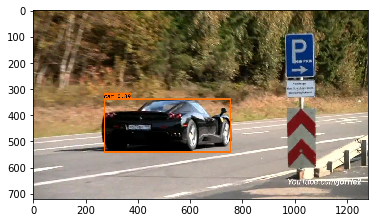

In [47]:
out_scores, out_boxes, out_classes = predict(sess, "car1.jpg")

Found 4 boxes for 0004.jpg
car 0.63 (400, 285) (515, 327)
car 0.66 (95, 297) (227, 342)
car 0.68 (1, 321) (121, 410)
car 0.72 (539, 277) (658, 318)


/home/shangeth/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


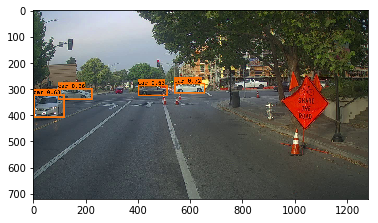

In [48]:
out_scores, out_boxes, out_classes = predict(sess, "0004.jpg")

Found 2 boxes for 0018.jpg
car 0.76 (71, 362) (242, 419)
car 0.77 (340, 339) (553, 401)


/home/shangeth/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


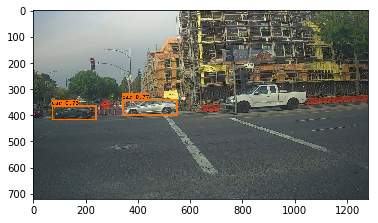

In [51]:
out_scores, out_boxes, out_classes = predict(sess, "0018.jpg")

Found 2 boxes for 0021.jpg
car 0.62 (691, 292) (914, 403)
truck 0.72 (88, 317) (493, 450)


/home/shangeth/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


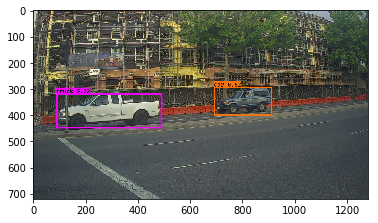

In [54]:
out_scores, out_boxes, out_classes = predict(sess, "0021.jpg")